# Here is a simple script to generate gravitational waves.

Seted up two gravitational wave detectors 90 degrees apart.

You can simply set the preprocessing method.

The default preprocessing method is to take the absolute value, normalize it, and compress it.

Also, include the method of generating noise.

Output to /kaggle/working/signal and /kaggle/working/noise


# Install module and import

In [2]:
import numpy as np
import pandas as pd
import torch as tc
import pyfstat,sys,os,io,cv2,warnings
from pyfstat.utils import get_sft_as_arrays
from typing import TYPE_CHECKING, Iterable, Optional
import logging,shutil,tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Clear unnecessary log

In [3]:
"""fc:"set_up_logger" is come from https://www.kaggle.com/code/crischir/pyfstat-tutorial-adapted-to-kaggle"""
def set_up_logger(
    outdir: Optional[str] = None,
    label: Optional[str] = "pyfstat",
    log_level: str = "INFO",  # FIXME: Requires Python 3.8 Literal["CRITICAL", "ERROR", "WARNING", "INFO", "DEBUG"] = "INFO",
    streams: Optional[Iterable["io.TextIOWrapper"]] = (sys.stdout,),
    append: bool = True,
) -> logging.Logger:
#     """Add file and stream handlers to the `pyfstat` logger.
#     Handler names generated from ``streams`` and ``outdir, label``
#     must be unique and no duplicated handler will be attached by
#     this function.
#     Parameters
#     ----------
#     outdir:
#         Path to outdir directory. If ``None``, no file handler will be added.
#     label:
#         Label for the file output handler, i.e.
#         the log file will be called `label.log`.
#         Required, in conjunction with ``outdir``, to add a file handler.
#         Ignored otherwise.
#     log_level:
#         Level of logging. This level is imposed on the logger itself and
#         *every single handler* attached to it.
#     streams:
#         Stream to which logging messages will be passed using a
#         StreamHandler object. By default, log to ``sys.stdout``.
#         Other common streams include e.g. ``sys.stderr``.
#     append:
#         If ``False``, removes all handlers from the `pyfstat` logger
#         before adding new ones. This removal is not propagated to
#         handlers on the `root` logger.
#     Returns
#     -------
#     obj:
#         Configured instance of the ``logging.Logger`` class.
#     """
    logger = logging.getLogger("pyfstat")
    logger.setLevel(log_level)

    if not append:
        for handler in logger.handlers:
            logger.removeHandler(handler)
    else:
        for handler in logger.handlers:
            handler.setLevel(log_level)

    stream_names = [
        handler.stream.name
        for handler in logger.handlers
        if type(handler) == logging.StreamHandler
    ]
    file_names = [
        handler.baseFilename
        for handler in logger.handlers
        if type(handler) == logging.FileHandler
    ]

    common_formatter = logging.Formatter(
        "%(asctime)s.%(msecs)03d %(name)s %(levelname)-8s: %(message)s",
        datefmt="%y-%m-%d %H:%M:%S",  # intended to match LALSuite's format
    )

    for stream in streams or []:
        if stream.name in stream_names:
            continue
        stream_handler = logging.StreamHandler(stream)
        stream_handler.setFormatter(common_formatter)
        stream_handler.setLevel(log_level)
        logger.addHandler(stream_handler)

    if label and outdir:
        os.makedirs(outdir, exist_ok=True)
        log_file = os.path.join(outdir, f"{label}.log")

        if log_file not in file_names:

            file_handler = logging.FileHandler(log_file)
            file_handler.setFormatter(common_formatter)
            file_handler.setLevel(log_level)
            logger.addHandler(file_handler)

    return logger


In [4]:
def Normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,f2,...)"""
    #[batch,f1,f2]->dim[1,2]
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    var=x.std(dim=dim,keepdim=True)
    return (x-mean)/var

# Generate gravitational waves

In [5]:
def generate(signal_rate=0.01)->np.ndarray:
    """signal_rate must >=0
        output=[H1_signal,L1_signal]
        """
    writer_kwargs = {
        "label": "single_detector_gaussian_noise",
        "outdir": "PyFstat_example_data",
        "tstart": 1238166018,
        "duration": 365 * 86400,
        "detectors": "H1",
        "sqrtSX": 1e-22,
        "Tsft": 1800,
        "SFTWindowType": "tukey",
        "SFTWindowBeta": 0.01,
    }
    signal_parameters = {
        "F0": np.random.randint(50,500),#meta_data_arange=(50,400)
        "F1": -1e-9*(1+np.random.randn()*0.01),#[-1e-9,0]
        "Alpha": 2*np.pi*np.random.rand(),#(0,2pi)
        "Delta": 0.5*np.pi*(1-np.random.rand()),#[-pi/2,pi/2]
        "h0": 1e-22*signal_rate,
        "cosi": 1-2*np.random.rand()*0,#(-1,1)Affects signal strength
        "psi": 0.5*np.pi*(1-np.random.rand()),#(-pi/2,pi/2)
        "phi": 2*np.pi*np.random.rand(),#(0,2pi)
        "tref": writer_kwargs["tstart"],
    }

    writer = pyfstat.Writer(**writer_kwargs, **signal_parameters)
    writer.make_data()# Create SFTs

    frequency, timestamps, fourier_data_H1 = get_sft_as_arrays(writer.sftfilepath)#H1_detector

    signal_parameters["psi"]+np.pi/2#90 degree
    writer = pyfstat.Writer(**writer_kwargs, **signal_parameters)
    writer.make_data()
    
    frequency, timestamps, fourier_data_L1 = get_sft_as_arrays(writer.sftfilepath)#L1_detector

    
    ####preprocessing method
    fourier_data_H1["H1"]/=1e-22
    fourier_data_L1["H1"]/=1e-22
    
    output_H=np.absolute(fourier_data_H1["H1"])[::-1]
    #L1 is another detector with a 90 degree difference
    output_L=np.absolute(fourier_data_L1["H1"])[::-1]
    
    ####compress gravitational waves to speed up training
    output=np.stack((output_H,output_L),axis=0)
    output=output.transpose(1,2,0)
    #output.shape=(200~360(perhaps),17520, 2)
    output=cv2.resize(output,(3500,360)).transpose(2,0,1)#Compression_ratio=17520/3500~=5
    
    return frequency,Normalization(tc.from_numpy(output))

# The output path

In [6]:
"""path settings"""

logger = set_up_logger(label="0_generating_noise", log_level="WARNING")
file_path="/kaggle/working/"
try:
    os.mkdir(path=file_path+"signal")
    os.mkdir(path=file_path+"noise")
except:
    shutil.rmtree(file_path+"signal")#delete folder
    shutil.rmtree(file_path+"noise")#delete folder
    os.mkdir(path=file_path+"signal")
    os.mkdir(path=file_path+"noise")

# Show gravitational waves

torch.Size([2, 360, 3500])


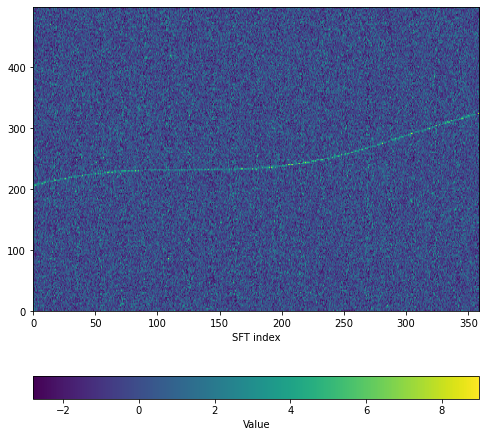

In [7]:
"""show Generate noisy gravitational waves signal_rate=0.1"""
frequency,output=generate(signal_rate=0.1)
print(output.shape)
output=output.numpy().transpose(1,2,0)
output=cv2.resize(output,(500,360)).transpose(2,0,1)

fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax.set(xlabel="SFT index")
c = ax.pcolorfast(np.arange(output.shape[1]),np.arange(output.shape[2]), output[0])
fig.colorbar(c, ax=ax, orientation="horizontal", label="Value")
fig

# Output gravitational waves

In [8]:
"""In this script, noisy gravitational waves (signal_rate=0.01) are generated in /kaggle/working/signal
     Generate noise without gravitational waves in /kaggle/working/noise"""

total=10#noise_generate_time+signal_generate_time
signal_rate=0.01
    
time=tqdm.tqdm(total=total)
for i in range(total//2):
    frequency,output=generate(signal_rate=signal_rate)#Generate noisy gravitational waves 
    #output:tc.Tensor to np.ndarray ->output.numpy()
    tc.save(output,file_path+f"signal/_{i}.pth")
    frequency,output=generate(0)#Generate noisy
    tc.save(output,file_path+f"noise/_{i}.pth")
    time.update(2)

100%|██████████| 10/10 [00:35<00:00,  3.55s/it]